# Accuinsight+ Modeler AutoDL tutorial
## 심전도(ECG) 데이터를 분류하는 CNN 모델
## 목차
1. [분석 개요](#분석_개요)
2. [데이터](#데이터)
3. [CNN 모델 생성 및 학습](#CNN_모델_구성_및_학습)
4. [학습 결과 시각화](#학습_결과_시각화)
5. [Modeler AutoDL 사용방법](#AutoDL_사용방법)

<a id='분석_개요'></a>
## 분석 개요
- 본 예제에서는 kaggle에서 제공하는 [심전도(ECG) 데이터](https://www.kaggle.com/shayanfazeli/heartbeat)를 사용하여 심장박동 패턴을 분류하는 CNN 모델을 만들고,  
Accuinsight+ Modeler의 __AutoDL__ 기능을 사용하여 하이퍼파라미터를 최적화하는 과정을 설명합니다.
- CNN 모델은 3개의 1D convolution layer와 2개의 fully-connected layer로 구성되어 있습니다.
- 다음의 출처를 참고하여 코드를 재구성했습니다. ([출처](https://www.kaggle.com/gregoiredc/arrhythmia-on-ecg-classification-using-cnn))

In [86]:
from tensorflow.keras.layers import Input, Dense, Convolution1D, MaxPool1D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
import tensorflow.keras as keras
from keras.utils.np_utils import to_categorical

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import os
import easydict

<a id='데이터'></a>
## 데이터
- [CNN 모델 생성 및 학습](#CNN_모델_구성_및_학습) 챕터에서 train 데이터를 7:3 비율로 나누어 train, validation 데이터로 사용할 것입니다.
- 데이터는 정상 클래스(N)와 4개의 부정맥 클래스(Q, V, S, F)로 구성되어 있으며, N 클래스의 빈도수가 압도적으로 높은 불균형 데이터입니다.

데이터를 불러옵니다.

In [2]:
train = pd.read_csv("data/mitbih_train.csv", header=None)
test = pd.read_csv("data/mitbih_test.csv", header=None)

In [4]:
train = train.rename({187:'class'}, axis='columns')
test = test.rename({187:'class'}, axis='columns')

데이터 개수를 확인합니다.

In [3]:
print("총 데이터 개수: ", len(train) + len(test))
print("train 데이터 개수: ", len(train))
print("test 데이터 개수: ", len(test))

총 데이터 개수:  109446
train 데이터 개수:  87554
test 데이터 개수:  21892


In [69]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,class
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,class
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


모델 입력 전 train 데이터의 순서를 랜덤하게 섞습니다.

In [70]:
train=train.sample(frac=1).reset_index(drop=True)

class별 빈도수를 확인합니다. 부정맥 클래스(Q, V, S, F)에 비해 정상 정상 클래스(N)의 비율이 매우 높은 것을 확인할 수 있습니다.

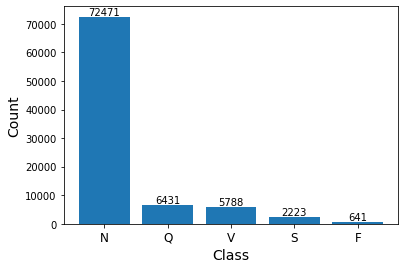

In [7]:
classes = ['N','Q','V','S','F']
index = np.arange(len(classes))

bar = plt.bar(index, train['class'].value_counts())
plt.xlabel('Class', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(index, classes, fontsize=12)

for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%d' % int(height), ha='center', va='bottom')

plt.show()

class별 ECG 데이터 예시입니다.

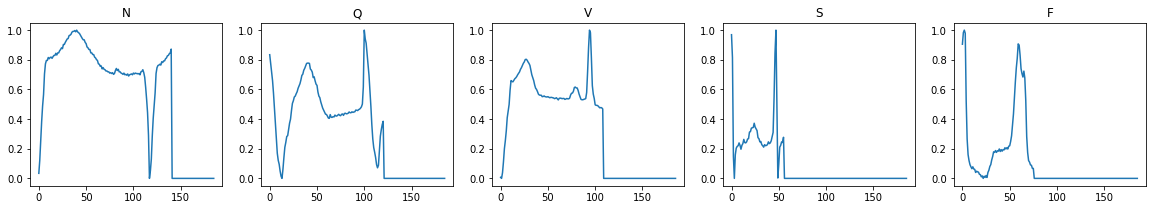

In [8]:
c = train.groupby('class', group_keys=False).apply(lambda train : train.sample(1))

fig, ax = plt.subplots(1, 5, figsize=(20, 3))
ax[0].plot(c.iloc[0,:186])
ax[0].set_title("N")
ax[1].plot(c.iloc[4,:186])
ax[1].set_title("Q")
ax[2].plot(c.iloc[2,:186])
ax[2].set_title("V")
ax[3].plot(c.iloc[1,:186])
ax[3].set_title("S")
ax[4].plot(c.iloc[3,:186])
ax[4].set_title("F")

plt.show()

<a id='CNN 모델 구성 및 학습'></a>

<a id='CNN_모델_구성_및_학습'></a>
## CNN 모델 생성 및 학습

- 이번 예제에서 최적화할 하이퍼파라미터는 아래와 같습니다.
  - `num_node`: convolution layer와 dense layer의 노드 개수
  - `batch_size`: 모델 학습의 반복 한 회당 사용되는 샘플의 개수
  - `learning_rate`: 경사하강법을 통해 모델을 학습시키는 데 사용되는 스칼라값으로, 각 반복에서 경사에 곱해지는 값
  - `dropout_rate`: 모델의 일반화를 위해 layer에서 일부 노드만을 무작위로 선택하는 dropout 기법을 사용하는데, 이 때 선택되는 노드의 비율
- AutoDL을 사용하기 위해서는 __argparse__를 통해 하이퍼파라미터를 설정해야 하는데,  
  jupyter notebook에서는 argparse 사용이 불가능하기 때문에 __easydict__를 통해 하이퍼파라미터를 설정합니다.  
  실제로 AutoDL에 사용되는 [autodl_cnn_ecg_classification.py](autodl_cnn_ecg_classification.py)에서는 argparse를 통해 하이퍼파라미터를 설정합니다.

In [71]:
args = easydict.EasyDict({
    "num_node": 64,
    "batch_size": 32,
    "num_epochs": 20,
    "learning_rate": 5e-4,
    "dropout_rate": 0.5})

데이터에서 feature와 class를 분리합니다.

In [72]:
y_train = to_categorical(train['class'])
y_test = to_categorical(test['class'])

X_train = train.iloc[:, :186].values
X_test = test.iloc[:, :186].values
X_train = X_train.reshape(len(X_train), X_train.shape[1], 1)
X_test = X_test.reshape(len(X_test), X_test.shape[1], 1)

- AutoDL에서 평가 지표를 수집할 수 있도록 epoch이 종료될 때마다 평가 지표(Accuracy)를 출력합니다.
- 이번 예제에서는 __평가 지표명=평가 지표값__ 형식으로 평가 지표를 출력하는데,  
  평가 지표 설정 방법은 [Modeler AutoDL 사용방법](#AutoDL_사용방법) 챕터에서 좀 더 자세히 다룰 것입니다.

In [73]:
class MetricHistory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print("\nEpoch {}".format(epoch + 1))
        print("Train-acc={:.4f}".format(logs['accuracy']))
        print("Validation-acc={:.4f}".format(logs['val_accuracy']))

CNN 모델을 생성하고 학습시키는 함수입니다.

In [5]:
def network(X_train, y_train):
    
    # 3개의 1D convolution layer와 2개의 fully-connected layer로 구성되어 있습니다.
    im_shape = (X_train.shape[1], 1)
    inputs_cnn = Input(shape=(im_shape), name='inputs_cnn')
    conv1_1 = Convolution1D(args.num_node, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1 = BatchNormalization()(conv1_1)
    pool1 = MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1 = Convolution1D(args.num_node, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1 = BatchNormalization()(conv2_1)
    pool2 = MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1 = Convolution1D(args.num_node, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1 = BatchNormalization()(conv3_1)
    pool3 = MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten = Flatten()(pool3)
    # dropout 기법을 사용합니다.
    dropout1 = Dropout(args.dropout_rate)(flatten)
    dense_end1 = Dense(args.num_node, activation='relu')(dropout1)
    dropout2 = Dropout(args.dropout_rate)(dense_end1)
    dense_end2 = Dense(args.num_node/2, activation='relu')(dropout2)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    model = Model(inputs=inputs_cnn, outputs=main_output)
    
    # Adam optimizer를 사용합니다.
    model.compile(optimizer=Adam(lr=args.learning_rate),
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])
    
    path = "./best_model"
    if not os.path.isdir(path):
        os.mkdir(path)
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
                 # validation loss가 가장 낮은 모델의 체크 포인트가 best_model 폴더에 저장됩니다.
                 ModelCheckpoint(filepath='best_model/best_model.h5', monitor='val_loss', save_best_only=True),
                 MetricHistory()]

    history = model.fit(X_train, y_train,
                        epochs=args.num_epochs,
                        callbacks=callbacks,
                        batch_size=args.batch_size,
                        # train 데이터를 7:3 비율로 나누어 train, validation 데이터로 사용합니다.
                        validation_split=0.3,
                        shuffle=True)
    
    model.load_weights('best_model/best_model.h5')
    
    return model, history

In [76]:
model, history = network(X_train, y_train)

Epoch 1/20
1915/1916 [============================>.] - ETA: 0s - loss: 0.3140 - accuracy: 0.9120
Epoch 1
Train-acc=0.9120
Validation-acc=0.9619
1916/1916 [==============================] - 42s 22ms/step - loss: 0.3139 - accuracy: 0.9120 - val_loss: 0.1408 - val_accuracy: 0.9619
Epoch 2/20
1915/1916 [============================>.] - ETA: 0s - loss: 0.1779 - accuracy: 0.9515
Epoch 2
Train-acc=0.9515
Validation-acc=0.9675
1916/1916 [==============================] - 46s 24ms/step - loss: 0.1778 - accuracy: 0.9515 - val_loss: 0.1204 - val_accuracy: 0.9675
Epoch 3/20
1915/1916 [============================>.] - ETA: 0s - loss: 0.1521 - accuracy: 0.9587
Epoch 3
Train-acc=0.9587
Validation-acc=0.9738
1916/1916 [==============================] - 42s 22ms/step - loss: 0.1520 - accuracy: 0.9587 - val_loss: 0.1101 - val_accuracy: 0.9738
Epoch 4/20
1914/1916 [============================>.] - ETA: 0s - loss: 0.1324 - accuracy: 0.9635
Epoch 4
Train-acc=0.9635
Validation-acc=0.9733
1916/1916 [====

<a id='학습_결과_시각화'></a>
## 학습 결과 시각화

모델의 학습 과정 그래프를 그리는 함수입니다.

In [152]:
def evaluate_model(history, X_test, y_test, model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Model - Accuracy')
    ax[0].legend(['Training', 'Validation'], loc='lower right')

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Model - Loss')
    ax[1].legend(['Training', 'Validation'], loc='upper right')
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

confusion matrix를 그리는 함수입니다.

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.ylim(-0.5, 4.5)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Accuracy: 98.27%


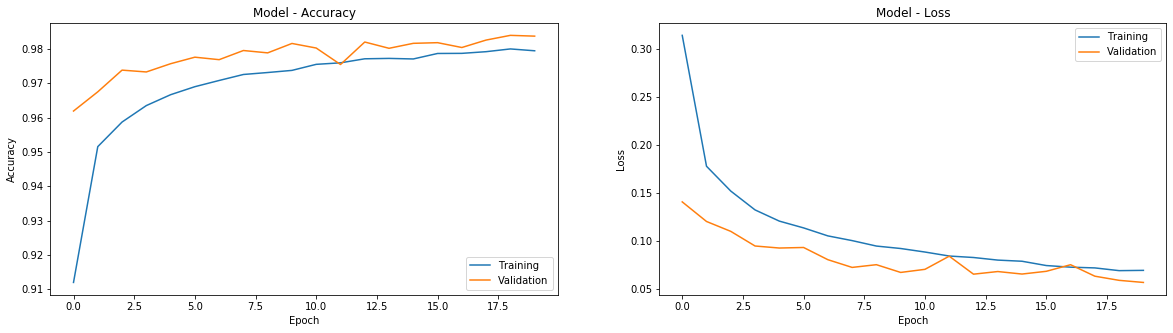

In [153]:
evaluate_model(history, X_test, y_test, model)

Normalized confusion matrix


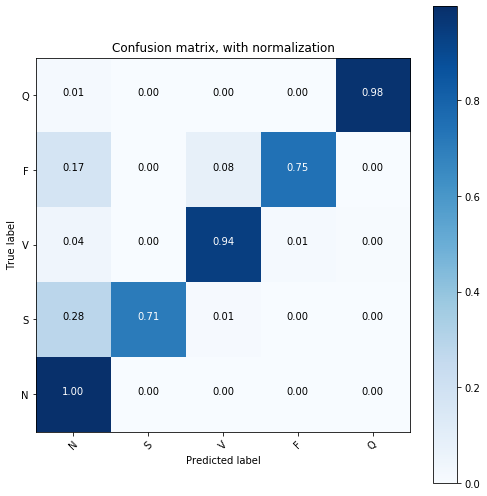

In [154]:
# Compute confusion matrix
y_pred = model.predict(X_test)
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(7, 7))
plot_confusion_matrix(cnf_matrix,
                      classes=['N', 'S', 'V', 'F', 'Q'],
                      normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

<a id='AutoDL_사용방법'></a>
## Modeler AutoDL 사용방법
- 지금까지 심장박동 패턴을 분류하는 CNN 모델 예제를 살펴보았습니다.
- 이번 챕터에서는 위에서 살펴본 CNN 모델의 하이퍼파라미터를 AutoDL 기능을 사용해 최적화하는 과정에 대해 다룰 것입니다.